# Question 4:

### Data Cleaning:

In [1]:
import numpy as np
import pandas as pd
import scipy
import statsmodels as sm
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

df_raw = pd.read_csv('https://dl.dropboxusercontent.com/s/9rp201wrk9m6qpb/data_final.csv',index_col=0)
columns = list(df_raw.columns)

df = df_raw[columns].copy()
df['D'] = df['D'].astype(np.float64)



k=11 # Treatment starts at 11
df_past_11 = df[df['t'] > 11].copy()
df_past_11.groupby('i')['D'].std().mean()

# Generate binary variable indicating if belongs to control or treatment group:
nObs = df[['D','i']].groupby('i').sum().shape[0]
ntreat = df[['D','i']].groupby('i').sum().query('D>0').shape[0]
shareTreat = ntreat/nObs
idTreatedList= df[['D','i']].groupby('i').sum().query('D>0').index.tolist() # Get list of treated people

# Add group tag:
df['Group: T'] = df['i'].isin(idTreatedList).astype(int)

# Define regression:
def olsRegression(XX, Y):

    bbeta = np.dot(np.linalg.inv(np.dot(XX.T,XX)), np.dot(XX.T,Y))

    return bbeta

# Get residual U:
df['U'] = df[['Y']].values - np.matmul(df[['X1','X2']].values,olsRegression(df[['X1','X2']].values,df[['Y']].values))

# Add Lagged data:
#-----------------

#First lag:
dfLag = df.copy().rename(columns={'Y': 'Y_Lag', 'U':'U_Lag', 'X1':'X1_Lag', 'X2':'X2_Lag', 'D':'D_Lag'})
dfLag['t'] = (dfLag['t'] + 1)

#Obtain lagged variable:
df = df.merge(dfLag[['Y_Lag','U_Lag','X1_Lag','X2_Lag','D_Lag','i','t']], how = 'left', on=['i','t'])

#Second lag:
dfLagLag = df.copy().rename(columns={'Y': 'Y_LagLag', 'U':'U_LagLag'})
dfLagLag['t'] = (dfLagLag['t'] + 2)

#Obtain lagged variable:
df = df.merge(dfLagLag[['Y_LagLag','U_LagLag','i','t']], how = 'left', on=['i','t'])
df['DeltaU'] = df['U'] - df['U_Lag']


df['Delta_Y']   = df['Y']-df['Y_Lag']
df['Delta_X1']  = df['X1']-df['X1_Lag']
df['Delta_X2']  = df['X2']-df['X2_Lag']
df['Delta_D']   = df['D']-df['D_Lag']

df_new = (df[['X1','X2','D','X1_Lag',
            'X2_Lag','D_Lag','Y','Y_Lag',
            'Delta_X1','Delta_X2','Delta_Y',
            'Delta_D','i','t','Group: T']]
            .copy()
            .dropna()
            .query('`Group: T` == 1')
            .query('t >= 1')
            .query('t <= 30')
            )

In [2]:
def checkTrends(data):

    meanOverTimeTreatmet = df.loc[df['Group: T']==1,:].groupby('t').mean().reset_index()[['Y','t']]
    meanOverTimeControl = df.loc[df['Group: T']==0,:].groupby('t').mean().reset_index()[['Y','t']]
    plt.plot(meanOverTimeTreatmet['t'],meanOverTimeTreatmet['Y'], label='Treatment')
    plt.plot(meanOverTimeControl['t'],meanOverTimeControl['Y'], label='Control')
    plt.legend()
    plt.xlim([0, 20])
    plt.show()

### Difference in Differences Estimator

In [3]:
def differenceDifferencesEstimator(depvar = 'DeltaU', k=11, w=1, data=df.copy()):

    #This estimates α for Model (A):

    dfGroup0 = data.loc[data['Group: T']==0,[depvar,'t']]
    dfGroup1 = data.loc[data['Group: T']==1,[depvar,'t']]

    #Means for control group
    dfGroup0_pre = dfGroup0.loc[dfGroup0['t'].isin([k-w]),[depvar]].mean()[0]
    dfGroup0_post = dfGroup0.loc[dfGroup0['t'].isin([k]),[depvar]].mean()[0]

    #Means for treatment group
    dfGroup1_pre = dfGroup1.loc[dfGroup1['t'].isin([k-w]),[depvar]].mean()[0]
    dfGroup1_post = dfGroup1.loc[dfGroup1['t'].isin([k]),[depvar]].mean()[0]

    alpha = (dfGroup1_post - dfGroup1_pre) - (dfGroup0_post - dfGroup0_pre)

    print('Treatment Effect: ', alpha)

    return alpha

### IV Estimator

In [4]:
def ivEstimator(depvar='Y', data = df.copy()):

    df_new = data
    df_new = df_new.loc[df_new['t']==11,:]
    ZZ = df_new[['Z1','X1','X2']].values
    XX = df_new[['X1','X2']].values
    YY = df_new[[depvar]].values
    Treatment= df_new[['D']].values

    # Apply Chrchane Orcutt:
    UU = YY-np.matmul(XX,olsRegression(XX,YY))

    gamma = olsRegression(ZZ,Treatment)
    THat= np.matmul(ZZ,gamma)

    # Second stage estimation:
    iv = olsRegression(THat,UU)

    #Wald Estimator:
    wald = iv/(THat.mean()*(1-THat.mean())).mean()

    return wald, gamma, iv

### Selection Bias Estimation

In [5]:
def selectionBiasEstimator(depvar='Y',data=df.copy()):

    df_new = df.copy()
    df_new = df_new.loc[df['t']==11,:]

    #Compute Probit:
    propensity_model = smf.probit('D ~ Z1 + Z2', data=df_new).fit()
    propensity_model.summary2()
    df_new['P'] = propensity_model.predict(df_new)
    df_new['P_icdf'] = scipy.stats.norm.ppf(df_new['P'])

    # Estimate treatment effect in the limit:
    df_low_prob = df_new.loc[df_new['P']<0.000001,:]
    df_high_prob = df_new.loc[df_new['P']>1-0.000001,:]

    # Compute OLS in both samples:
    beta_hp = olsRegression(df_high_prob[['X1','X2']].values,df_high_prob[[depvar]].values)
    beta_lp = olsRegression(df_low_prob[['X1','X2']].values,df_low_prob[[depvar]].values)

    # Compute the differences between \mu_1(X) and \mu_2(X):
    alpha = np.mean(np.matmul(df_new[['X1','X2']].values, beta_hp) - np.matmul(df_new[['X1','X2']].values,beta_lp))

    return alpha

### Balestra Nerlov Estimation

In [6]:

def balestraNerloveEstimator(df1, depvar, zVariableList):

    df_base = (df1.copy()
                .dropna()
                .query('t >= 1')
                .query('t <= 20')
                )

    df = (df_base.copy()
                .dropna()
                .query('`Group: T` == 1')
                )

    xi_mean_list=[]
    yi_mean_list=[]
    alpha_1_list=[]
    gamma_list = []
    id_list = df.i.unique()

    for ii in id_list:
        df_i = df.query('i =='+str(ii))
        xx_temp = df_i[zVariableList].values
        y_temp = df_i[[depvar]].values
        gamma = olsRegression(xx_temp, y_temp)
        # Take Means:
        xx_temp_mean = xx_temp.mean(0).reshape(xx_temp.shape[1],1)
        y_temp_mean = y_temp.mean()
        xi_mean_list.append(xx_temp_mean)
        yi_mean_list.append(y_temp_mean)
        # Obtain alpha_1
        alpha_1 = y_temp_mean - np.matmul(gamma.T,xx_temp_mean)
        gamma = gamma.reshape(len(gamma),).tolist()
        alpha_1_list.append(alpha_1[0][0])
        gamma_list.append(gamma)

    gamma_hat = np.array(gamma_list).mean(0)
    alpha_1 = np.array(alpha_1_list).mean()

    #Compute sigma^2:
    Y_flat = df[[depvar]].values
    X_flat = df[zVariableList].values
    uhat = (Y_flat - np.matmul(X_flat,
                                gamma_hat.reshape(len(gamma_hat),1)
                                ))
    sigma_residual = (1/df.shape[0]) * np.sum(uhat**2)

    #Compute sigma_u
    sigma_mu_residual = 0
    Nobs=len(xi_mean_list)
    for ii in range(len(xi_mean_list)):
        sigma_mu_residual += 1/Nobs * (yi_mean_list[ii] -
        np.matmul(gamma_hat,xi_mean_list[ii].reshape(xi_mean_list[ii].shape[0],1))
        - alpha_1)**2

    rho = sigma_mu_residual[0]/sigma_residual

    #Varepsilon and eta:
    T = len(df.t.unique())
    varepsilon = sigma_residual*((1-rho)+T*rho)
    eta = sigma_residual*(1-rho)

    Nobs = len(df_base['i'].unique())

    # Construct Omega matrix:
    C = np.eye(T)*eta
    C[0,0] = varepsilon
    I_n = np.eye(Nobs)
    OOmega = np.kron(I_n,C)

    Y_flat = df_base[[depvar]].values
    X_flat = df_base[zVariableList].values

    # Transform x's and y's to do gls estimation:

    # Second Round Estimation:
    OOmega_inv = np.linalg.inv(OOmega)

    gammaGLS = np.dot(  np.linalg.inv(
                        np.dot(
                        np.dot(X_flat.T,OOmega_inv),
                        X_flat
                        )
                        ),
                        np.dot(
                        np.dot(X_flat.T,OOmega_inv),
                        Y_flat
                        )
                        )

    # Compute residuals for the whole database:
    Y_flat = df1[[depvar]].values
    X_flat = df1[zVariableList].values

    shocks = Y_flat - np.matmul(X_flat,gammaGLS)

    return gammaGLS, shocks

### First Check Common Trends Between Treatment and Control Group

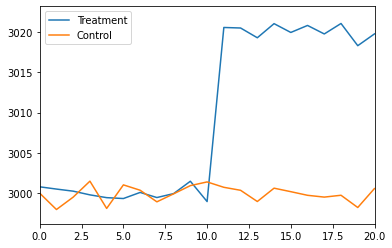

In [7]:
checkTrends(df)

### Compute Estimation

#### Model A:

In [8]:
# Model A:
# DID
alphaDIDA = differenceDifferencesEstimator('U',k,1, df)

# IV: 
waldA, gamma, iv = ivEstimator('U',df)

# Selection Bias:
alphaA = selectionBiasEstimator('Y',df)


# Balestra Nerlove:
zVariableList = ['X1','X2','D','X1_Lag','X2_Lag','D_Lag','Y_Lag']
gammaGLSA, shocks = balestraNerloveEstimator(df, 'Y', zVariableList)
df['error_modelA'] = shocks

Treatment Effect:  20.2266568845401
Optimization terminated successfully.
         Current function value: 0.216613
         Iterations 8


#### Model B:

In [9]:
# Model B:

# DID:
alphaDIDB = differenceDifferencesEstimator('DeltaU',11,1, df)

# IV:
waldB, gamma, iv = ivEstimator('DeltaU',df)

# Selection Bias:
alphaB = selectionBiasEstimator('DeltaU',df)

# Balestra Nerlove:
zVariableList = ['Delta_X2','Delta_X1','Delta_D']
gammaGLSB, shocks = balestraNerloveEstimator(df, 'Delta_Y', zVariableList)
df['error_modelB'] = shocks

Treatment Effect:  20.315790866403216
Optimization terminated successfully.
         Current function value: 0.216613
         Iterations 8


### Cost Benefit Analysis:

In [10]:
#Compile all estimators (This is Net Benefit):
estimatorsA = {'DID': alphaDIDA,
'SB': waldA[0][0],
'IV': alphaA,
'BN': gammaGLSA[2][0]
}

estimatorsB = {'DID': alphaDIDB,
'SB': waldB[0][0],
'IV': alphaA,
'BN': gammaGLSB[-1][0]
}

In [12]:
# Benefit Analysis (I will always use the same residuals and value for discounting):
rho = gammaGLSA[-1]
r = ((1-rho)/rho)[0]


# Error Composition 1:
#---------------------

data_pre_post = df.query('t==10 | t==11')

# Estimate Net-Benefit:

#Information Set 1: Full Information

did_netbenefitA = estimatorsA['DID']/r
sb_netbenefitA = estimatorsA['SB']/r
iv_netbenefitA = estimatorsA['IV']/r
bn_netbenefitA = estimatorsA['BN']/r

#Information Set 2: Cost - Benefit (with Error)

did_netbenefit_errorA = np.mean(did_netbenefitA - data_pre_post.query('t==10').error_modelA)
sb_netbenefit_errorA = np.mean(sb_netbenefitA - data_pre_post.query('t==10').error_modelA)
iv_netbenefit_errorA = np.mean(iv_netbenefitA - data_pre_post.query('t==10').error_modelA)
bn_netbenefit_errorA = np.mean(bn_netbenefitA - data_pre_post.query('t==10').error_modelA)


#Information Set 1: Full Information

did_netbenefitB = estimatorsB['DID']/r
sb_netbenefitB = estimatorsB['SB']/r
iv_netbenefitB = estimatorsB['IV']/r
bn_netbenefitB = estimatorsB['BN']/r


#Information Set 2: Cost - Benefit (with Error)

did_netbenefit_errorB = np.mean(did_netbenefitB - data_pre_post.query('t==10').error_modelB)
sb_netbenefit_errorB = np.mean(sb_netbenefitB - data_pre_post.query('t==10').error_modelB)
iv_netbenefit_errorB = np.mean(iv_netbenefitB - data_pre_post.query('t==10').error_modelB)
bn_netbenefit_errorB = np.mean(bn_netbenefitB - data_pre_post.query('t==10').error_modelB)

estimates = pd.DataFrame(data={
'DID-A':np.array([estimatorsA['DID'], did_netbenefitA,did_netbenefit_errorA]),
'SB-A':np.array([estimatorsA['SB'], sb_netbenefitA,sb_netbenefit_errorA]),
'IV-A':np.array([estimatorsA['IV'], iv_netbenefitA,iv_netbenefit_errorA]),
'BN-A':np.array([estimatorsA['BN'], bn_netbenefitA,bn_netbenefit_errorA]),
'DID-B':np.array([estimatorsB['DID'], did_netbenefitB,did_netbenefit_errorB]),
'SB-B':np.array([estimatorsB['SB'], sb_netbenefitB,sb_netbenefit_errorB]),
'IV-B':np.array([estimatorsB['IV'], iv_netbenefitB,iv_netbenefit_errorB]),
'BN-B':np.array([estimatorsB['BN'], bn_netbenefitB,bn_netbenefit_errorB])
}
)



In [13]:
estimates.index = ['Coefficient', 'Net Benefit', 'Cost Benefit Unc.']
print(estimates)

                       DID-A       SB-A       IV-A       BN-A      DID-B  \
Coefficient        20.226657  20.945966  19.594377  20.113260  20.315791   
Net Benefit        69.424500  71.893402  67.254309  69.035285  69.730437   
Cost Benefit Unc.  69.429140  71.898043  67.258949  69.039925  69.735325   

                        SB-B       IV-B       BN-B  
Coefficient        21.217962  19.594377  20.132397  
Net Benefit        72.826983  67.254309  69.100969  
Cost Benefit Unc.  72.831872  67.259197  69.105858  


### Plot cost benefit:

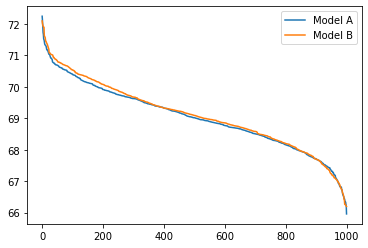

In [14]:
data_pre_post_t10 = data_pre_post.query('t==10')
plt.plot(bn_netbenefitA-data_pre_post_t10.sort_values(['error_modelA'])['error_modelA'].values, label='Model A')
plt.plot(bn_netbenefitB-data_pre_post_t10.sort_values(['error_modelB'])['error_modelB'].values, label='Model B')
plt.legend()
plt.savefig('Individual_CostBenefit.png')